In [ ]:
import pandas as pd
readings_summary  = pd.read_csv("readings_summary_raw.csv")

stations_to_keep = readings_summary[readings_summary['Percentage of Month (%)']>84.99]['randid'].unique().tolist()

df = pd.read_csv("../Data/PV_data_clean.csv")
df = df[df['randid'].isin(stations_to_keep)]

df["solar_power_plant"] = df["NOAAClimRegion"] + "_" + df["TempZone"] + "_" + df["HumidZone"] + "_" + df["bin_PlantSize_kW"].apply(lambda x: x[0])
pca_vals = pd.read_csv("../Data/solar_plant_pca_values.csv")

df_with_pca = df.merge(pca_vals, on='solar_power_plant', how='left')

C:\Users\loolz\AppData\Local\Temp\ipykernel_3308\4054564609.py:4: DtypeWarning: Columns (8,9,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Data/PV_data_clean.csv")


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.linear_model import LogisticRegressionCV
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df['power_outage'] = (df['PR'] < 0.1).astype(int)
df = df.drop('PR', axis=1)
df['Date'] = pd.to_datetime(df['Date'])
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day_of_week'] = df['Date'].dt.dayofweek
df['day_of_year'] = df['Date'].dt.dayofyear
df['hour'] = df['Date'].dt.hour
if 'randid' in df.columns:
    df = df.drop(['Date', 'randid'], axis=1)
else:
    df = df.drop(['Date'], axis=1)

numerical_features = df.select_dtypes(include=np.number).columns.tolist()
categorical_features = df.select_dtypes(include='object').columns.tolist()

if 'power_outage' in numerical_features:
    numerical_features.remove('power_outage')

print(f"Numerical Features: {numerical_features}")
print(f"Categorical Features: {categorical_features}")
print("\n")

Numerical Features: ['plant_age_months', 'snow_value_mm', 'total_daily_snow_mm', 'low_irradiation', 'cumulative_snow_mm', 'hurricane', 'nearest_hurricane', 'wind_speed_mean', 'rain_value_mm', 'nearest_rain', 'lightning', 'storm', 'duration_minutes_storm', 'nearest_storm', 'flood', 'duration_minutes_flood', 'nearest_flood', 'rain', 'weather_onset', 'year', 'month', 'day_of_week', 'day_of_year', 'hour']
Categorical Features: ['NOAAClimRegion', 'TempZone', 'HumidZone', 'bin_PlantSize_kW', 'active_snow_tickets', 'snow_bin_ticket_minutes', 'snow_affected_assets', 'snow_production_level', 'hurr_bin_ticket_minutes', 'hurr_affected_assets', 'hurr_production_level', 'HurricanePrep', 'HurricanePostInspection', 'storm_active_tickets', 'storm_bin_ticket_minutes', 'storm_affected_assets', 'storm_production_level', 'solar_power_plant']




In [7]:
initial_features = numerical_features + categorical_features
features_to_drop_high_missing = []
for col in initial_features:
    if df[col].isnull().sum() / len(df) > 0.8:
        features_to_drop_high_missing.append(col)
        print(f"Dropping '{col}' due to high missing value percentage.")

df = df.drop(columns=features_to_drop_high_missing)
df_original = df.copy()
numerical_features = [f for f in numerical_features if f not in features_to_drop_high_missing]
categorical_features = [f for f in categorical_features if f not in features_to_drop_high_missing]

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

X = df.drop('power_outage', axis=1)
y = df['power_outage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_processed = preprocessor.fit_transform(X_train)
if categorical_features:
    ohe_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
else:
    ohe_feature_names = []

all_transformed_features = numerical_features + list(ohe_feature_names)

if not all_transformed_features:
    raise ValueError("No features remaining after initial preprocessing and missing value handling. Please check your data.")

X_train_processed_df = pd.DataFrame(X_train_processed, columns=all_transformed_features, index=X_train.index)
X_test_processed = preprocessor.transform(X_test)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=all_transformed_features, index=X_test.index)

from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)
X_train_vt = selector.fit_transform(X_train_processed_df)
selected_features_vt = X_train_processed_df.columns[selector.get_support()]
print(f"Features after Variance Threshold: {len(selected_features_vt)} features selected.")
X_train_processed_df = X_train_processed_df[selected_features_vt]
X_test_processed_df = X_test_processed_df[selected_features_vt]

if X_train_processed_df.empty:
    raise ValueError("No features remaining after Variance Threshold. Adjust threshold or check data.")

k_to_select = min(20, X_train_processed_df.shape[1])
k_best_selector = SelectKBest(f_classif, k=k_to_select)
X_train_kbest = k_best_selector.fit_transform(X_train_processed_df, y_train)
selected_features_kbest = X_train_processed_df.columns[k_best_selector.get_support()]
print(f"Features after SelectKBest: {len(selected_features_kbest)} features selected.")
X_train_processed_df = X_train_processed_df[selected_features_kbest]
X_test_processed_df = X_test_processed_df[selected_features_kbest]

if X_train_processed_df.empty:
    raise ValueError("No features remaining after SelectKBest. Adjust k or check data.")

logistic_lasso = LogisticRegressionCV(
    penalty='l1',
    solver='liblinear', # 'liblinear' supports L1 penalty
    cv=5,               # Number of folds for cross-validation
    random_state=42,
    max_iter=10000
)
logistic_lasso.fit(X_train_processed_df, y_train)

selected_features_lasso = X_train_processed_df.columns[logistic_lasso.coef_[0] != 0]
print(f"Features after Lasso (L1) Logistic Regression: {len(selected_features_lasso)} features selected.")

if len(selected_features_lasso) == 0:
    raise ValueError("Lasso Logistic Regression selected no features. Consider adjusting parameters or feature scaling.")

X_train_final = X_train_processed_df[selected_features_lasso]
X_test_final = X_test_processed_df[selected_features_lasso]

estimator = LogisticRegression(solver='liblinear', random_state=42, max_iter=10000)
n_features_rfe = min(10, X_train_final.shape[1])
if n_features_rfe == 0:
    raise ValueError("No features available for RFE after Lasso. Check previous feature selection steps.")

rfe_selector = RFE(estimator=estimator, n_features_to_select=n_features_rfe, step=1)
rfe_selector.fit(X_train_final, y_train)
selected_features_rfe = X_train_final.columns[rfe_selector.get_support()]
print(f"Features after RFE: {len(selected_features_rfe)} features selected.")

if len(selected_features_rfe) == 0:
    raise ValueError("RFE selected no features. Consider adjusting RFE parameters or previous feature selection steps.")

X_train_model = X_train_final[selected_features_rfe]
X_test_model = X_test_final[selected_features_rfe]

print("\nFinal Features selected for the Logistic Regression Model:")
print(selected_features_rfe.tolist())

Dropping 'snow_bin_ticket_minutes' due to high missing value percentage.
Dropping 'snow_affected_assets' due to high missing value percentage.
Dropping 'hurr_bin_ticket_minutes' due to high missing value percentage.
Dropping 'hurr_affected_assets' due to high missing value percentage.
Dropping 'storm_bin_ticket_minutes' due to high missing value percentage.
Dropping 'storm_affected_assets' due to high missing value percentage.
Features after Variance Threshold: 68 features selected.
Features after SelectKBest: 20 features selected.
Features after Lasso (L1) Logistic Regression: 17 features selected.
Features after RFE: 10 features selected.

Final Features selected for the Logistic Regression Model:
['low_irradiation', 'lightning', 'NOAAClimRegion_Upper Midwest', 'TempZone_T6', 'TempZone_T7', 'HumidZone_H3', 'bin_PlantSize_kW_small', 'solar_power_plant_Southwest_T7_H3_s', 'solar_power_plant_West_T4_H4_s', 'solar_power_plant_West_T5_H4_l']


In [8]:
print("\nTraining Logistic Regression Model...")
logistic_model = LogisticRegression(random_state=42, solver='liblinear', max_iter=10000)
logistic_model.fit(X_train_model, y_train)
print("Model training complete.")


Training Logistic Regression Model...
Model training complete.


In [9]:
y_pred_train_proba = logistic_model.predict_proba(X_train_model)[:, 1]
y_pred_test_proba = logistic_model.predict_proba(X_test_model)[:, 1]

y_pred_train_class = logistic_model.predict(X_train_model)
y_pred_test_class = logistic_model.predict(X_test_model)

print("\n--- Model Evaluation on Training Set ---")
print(f"Accuracy: {accuracy_score(y_train, y_pred_train_class):.4f}")
print(f"Precision: {precision_score(y_train, y_pred_train_class):.4f}")
print(f"Recall: {recall_score(y_train, y_pred_train_class):.4f}")
print(f"F1-Score: {f1_score(y_train, y_pred_train_class):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_train, y_pred_train_proba):.4f}")
print("\nConfusion Matrix (Train):")
print(confusion_matrix(y_train, y_pred_train_class))

print("\n--- Model Evaluation on Test Set ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test_class):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_test_class):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_test_class):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_test_class):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_test_proba):.4f}")
print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, y_pred_test_class))

print("\nModel Coefficients:")
for feature, coef in zip(X_train_model.columns, logistic_model.coef_[0]):
    print(f"{feature}: {coef:.4f}")
print(f"Intercept: {logistic_model.intercept_[0]:.4f}")


--- Model Evaluation on Training Set ---
Accuracy: 0.8591
Precision: 0.7746
Recall: 0.2618
F1-Score: 0.3913
ROC-AUC: 0.8329

Confusion Matrix (Train):
[[23042   373]
 [ 3615  1282]]

--- Model Evaluation on Test Set ---
Accuracy: 0.8585
Precision: 0.7636
Recall: 0.2637
F1-Score: 0.3920
ROC-AUC: 0.8241

Confusion Matrix (Test):
[[5754  100]
 [ 902  323]]

Model Coefficients:
low_irradiation: 0.5952
lightning: 0.7935
NOAAClimRegion_Upper Midwest: 0.9657
TempZone_T6: -1.5814
TempZone_T7: 2.7048
HumidZone_H3: 1.2333
bin_PlantSize_kW_small: 0.8105
solar_power_plant_Southwest_T7_H3_s: 2.7048
solar_power_plant_West_T4_H4_s: 2.1527
solar_power_plant_West_T5_H4_l: -2.5095
Intercept: -2.2134



--- Interpreting Power Outage Likelihood ---
The logistic regression model outputs probabilities. A higher probability indicates a higher likelihood of a power outage (PR < 0.1).
Predictions are made based on a default threshold of 0.5 (probability >= 0.5 for power outage).


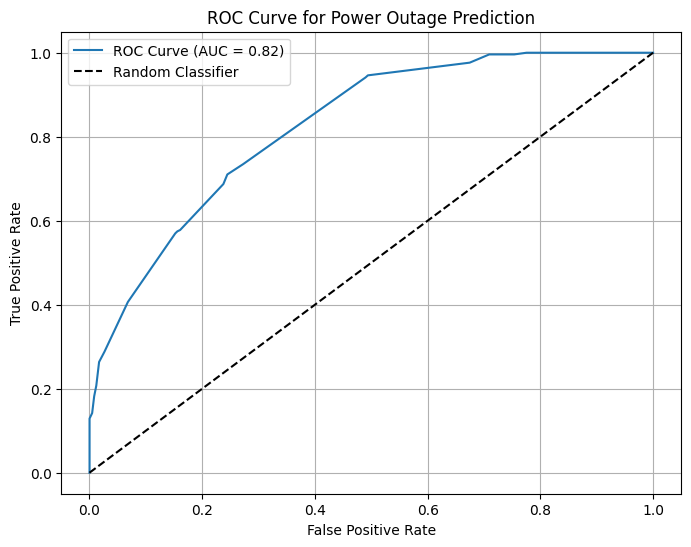

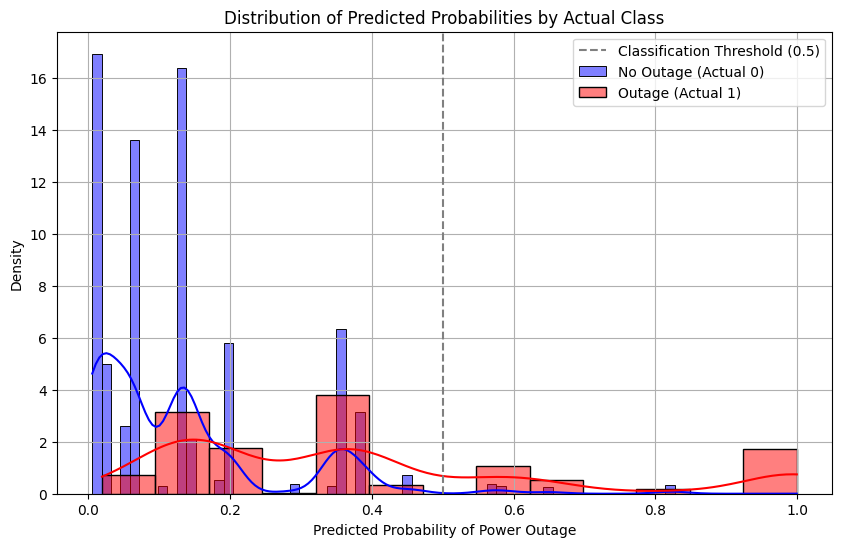

In [10]:
print("\n--- Interpreting Power Outage Likelihood ---")
print("The logistic regression model outputs probabilities. A higher probability indicates a higher likelihood of a power outage (PR < 0.1).")
print("Predictions are made based on a default threshold of 0.5 (probability >= 0.5 for power outage).")

fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_test_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Power Outage Prediction')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(y_pred_test_proba[y_test == 0], color='blue', label='No Outage (Actual 0)', kde=True, stat='density', alpha=0.5)
sns.histplot(y_pred_test_proba[y_test == 1], color='red', label='Outage (Actual 1)', kde=True, stat='density', alpha=0.5)
plt.axvline(x=0.5, color='gray', linestyle='--', label='Classification Threshold (0.5)')
plt.xlabel("Predicted Probability of Power Outage")
plt.ylabel("Density")
plt.title("Distribution of Predicted Probabilities by Actual Class")
plt.legend()
plt.grid(True)
plt.show()

This graph is an ROC (Receiver Operating Characteristic) curve, which is a common tool for evaluating the performance of binary classification models like your logistic regression. It plots the True Positive Rate (sensitivity) against the False Positive Rate (1-specificity) at various threshold settings. The curve rises from the bottom-left to the top-right, with a steeper curve towards the top-left indicating a better-performing model. The Area Under the Curve (AUC), given as 0.82, quantifies the overall performance, where a higher AUC (closer to 1) suggests that the model is better at distinguishing between the two classes (power outage vs. no power outage).

Here's how to interpret all four outcomes from the "Distribution of Predicted Probabilities by Actual Class" graph:

True Negatives (TN): These are the blue bars (Actual 0 - No Outage) that appear to the left of the 0.5 classification threshold. These are cases where there was no actual power outage, and your model correctly predicted a low probability (less than 0.5) of an outage. The tall blue bars concentrated near 0.0 probability are excellent examples of correctly identified non-outages.

True Positives (TP): These are the red bars (Actual 1 - Outage) that appear to the right of the 0.5 classification threshold. These are cases where there was an actual power outage, and your model correctly predicted a high probability (0.5 or greater) of an outage. The red bars concentrated towards 1.0 probability are instances of correctly identified outages.

So, to summarize for all four:

TP: Red bars to the right of the threshold.

TN: Blue bars to the left of the threshold.

FP: Blue bars to the right of the threshold.

FN: Red bars to the left of the threshold.

This graph is a very intuitive way to see how well your model separates the two classes and where its misclassifications occur relative to the chosen decision boundary.